### Libraries


In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re
import random

import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pnale\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Importing data

In [3]:
cv_other = pd.read_excel(r"EXPORT-CV-OTHER.xlsx")

In [4]:
cv_other

CV-Other                   Label Unnamed: 2
0                               WPW-SDR  Nervous system disease        NaN
1                          WPW syndrome  Nervous system disease        NaN
2                                   WPW  Nervous system disease        NaN
3                                   WPW  Nervous system disease        NaN
4        Wolff-Parkinson-White syndrome  Nervous system disease        NaN
...                                 ...                     ...        ...
1848        11/2018 pericardial exudate                     NaN        NaN
1849  11/2016 ischem.POCI kryptog., VES                     NaN        NaN
1850                                  0                     NaN        NaN
1851                                  0                     NaN        NaN
1852                 "extremely dipper"                     NaN        NaN

[1853 rows x 3 columns]

In [5]:
cv_other.dropna(subset = ['Label'], inplace=True) # drop missing values
cv_other = cv_other.sample(frac=1).reset_index(drop=True) # Shuffle the data set

In [6]:
data = cv_other

### Class size

In [7]:
data['Label'].value_counts()

Heart Disease             1207
Vascular Disease           260
Other                       56
Respiratory Disease         35
VES                         13
Cerebral Disease            11
Hormonal Disease            11
Nervous system disease       9
Name: Label, dtype: int64

In [8]:
len(data['CV-Other'].unique())

719

In [9]:
num_labels = len(data['Label'].value_counts())

### Pre-processing

In [10]:
# use pd.concat to join the new columns (after one-hot encoding) with our original dataframe

df = pd.concat([data,pd.get_dummies(data['Label'], prefix='Label')],axis=1)
df.drop(['Label'],axis=1, inplace=True)

In [11]:
df

CV-Other Unnamed: 2  Label_Cerebral Disease  \
0                                   Stent        NaN                       0   
1     Intraventricul. septum hyperthrophy        NaN                       0   
2                           Heart disease        NaN                       0   
3                                  Myxoma        NaN                       0   
4                        coronary failure        NaN                       0   
...                                   ...        ...                     ...   
1597                           arrhythmia        NaN                       0   
1598                  Atrial fibrillation        NaN                       0   
1599     Pulmonary Arterial Hypertensionn        NaN                       0   
1600                 venous insufficiency        NaN                       0   
1601                CVD LL+varices cruris        NaN                       0   

      Label_Heart Disease  Label_Hormonal Disease  \
0                       0                       0   
1                       1                       0   
2                       1                       0   
3                       1                       0   
4                       1                       0   
...                   ...                     ...   
1597                    1                       0   
1598                    1                       0   
1599                    0                       0   
1600                    0                       0   
1601                    0                       0   

      Label_Nervous system disease  Label_Other  Label_Respiratory Disease  \
0                                0            0                          0   
1                                0            0                          0   
2                                0            0                          0   
3                                0            0                          0   
4                                0            0                          0   
...                            ...          ...                        ...   
1597                             0            0                          0   
1598                             0            0                          0   
1599                             0            0                          1   
1600                             0            0                          0   
1601                             0            0                          0   

      Label_VES  Label_Vascular Disease  
0             0                       1  
1             0                       0  
2             0                       0  
3             0                       0  
4             0                       0  
...         ...                     ...  
1597          0                       0  
1598          0                       0  
1599          0                       0  
1600          0                       1  
1601          0                       1  

[1602 rows x 10 columns]

In [12]:
## Storing labels attributions in a list

df_labels = df[["Label_Heart Disease", "Label_Vascular Disease", "Label_Other", "Label_Respiratory Disease", "Label_VES", "Label_Hormonal Disease", "Label_Cerebral Disease", "Label_Nervous system disease"]]

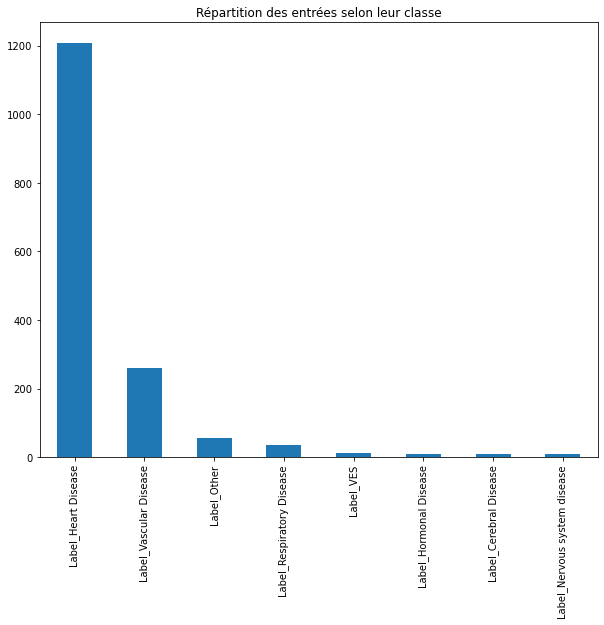

In [13]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.title('Répartition des entrées selon leur classe')

df_labels.sum(axis=0).plot.bar()
plt.savefig('images/repart.png')

In [14]:
def preprocess_entry(e):
    # Remove punctuations and numbers
    entry = re.sub('[^a-zA-Z]', ' ', e)

    # Single character removal
    entry = re.sub(r"\s+[a-zA-Z]\s+", ' ', entry)

    # Removing multiple spaces
    entry = re.sub(r'\s+', ' ', entry)

    return entry

In [15]:
## Cleaning the text of each entry

X = []
entries = list(df["CV-Other"])
for e in entries:
    X.append(preprocess_entry(e))

y = df_labels.values
#y = []
#labels = list(data['Label'])
#for l in labels:
#    y.append(l)

In [16]:
## Creation of train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

C:\Users\pnale\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7], y=[0 0 0 ... 0 7 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [18]:
sum_weights = sum(d_class_weights.values())

for k,v in d_class_weights.items():
    d_class_weights[k] = v/sum_weights


In [19]:
d_class_weights

{0: 0.0018727702563943339,
 1: 0.008809343887620273,
 2: 0.03667145478800067,
 3: 0.05840268725496404,
 4: 0.1433520505349117,
 5: 0.2628120926473382,
 6: 0.2628120926473382,
 7: 0.2252675079834327}

In [20]:
#y_train = np.array(pd.get_dummies(y_train, prefix='Label'))
#y_test = np.array(pd.get_dummies(y_test, prefix='Label'))

In [21]:
from nltk.tokenize import word_tokenize

## To use the Embedding dense, we need to found the number of unique words in our corpus. We use the Tokenizer function

tokenizer = Tokenizer() # num_words=5000
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

## We call the texts_to_sequences function to convert entries to their numeric counterpart

embedded_train = tokenizer.texts_to_sequences(X_train)
embedded_test = tokenizer.texts_to_sequences(X_test)

## Find the number of words in the longest entry and then to apply padding to the sentences having shorter lengths than the length of the longest entry

word_count = lambda entry: len(word_tokenize(entry))

longest_entry = max(X_test, key=word_count)
maxlen = len(word_tokenize(longest_entry))

X_test = pad_sequences(embedded_test, padding='post', maxlen=maxlen)

longest_entry = max(X_train, key=word_count)
maxlen = len(word_tokenize(longest_entry))

X_train = pad_sequences(embedded_train, padding='post', maxlen=maxlen)



In [22]:

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('datasets/glove.6B.100d.txt', encoding="utf8")

# Building a dictionary from the 400,000 words of the glove file

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

# Building the enbedding matrix

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
### Model with 4 denses
#
## one input layer
## one embedding layer
## one LSTM layer with 128 neurons
## one output layer with 8 neurons since we have 8 labels in the output
#import numpy
#numpy.random.seed(5)
#
#
#deep_inputs = Input(shape=(maxlen,))
#embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
#LSTM_Layer_1 = LSTM(128)(embedding_layer)
#dense_layer_1 = Dense(num_labels, activation='relu')(LSTM_Layer_1)
#model = Model(inputs=deep_inputs, outputs=dense_layer_1)
#
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
#
#print(model.summary())

In [64]:
## Model

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen, weights=[embedding_matrix], trainable=False))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(.5))
model.add(LSTM(128))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(.5))
model.add(Dense(num_labels, activation='softmax'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 6, 100)            51000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 169,280
Trainable params: 118,280
Non-trainable params: 51,000
_________________________________________________________________
None


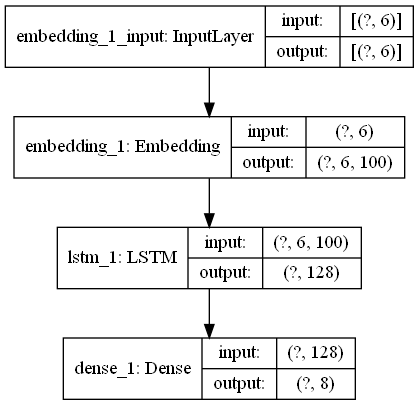

In [65]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='images/model_plot.png', show_shapes=True, show_layer_names=True)

In [66]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [67]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data = (X_test, y_test))

Epoch 1/20
9/9 [==============================] - 2s 277ms/step - loss: 0.3399 - acc: 0.6574 - val_loss: 0.2691 - val_acc: 0.7588
Epoch 2/20
9/9 [==============================] - 0s 25ms/step - loss: 0.2295 - acc: 0.7511 - val_loss: 0.1956 - val_acc: 0.7588
Epoch 3/20
9/9 [==============================] - 0s 17ms/step - loss: 0.1805 - acc: 0.7529 - val_loss: 0.1720 - val_acc: 0.7859
Epoch 4/20
9/9 [==============================] - 0s 18ms/step - loss: 0.1482 - acc: 0.7904 - val_loss: 0.1355 - val_acc: 0.8129
Epoch 5/20
9/9 [==============================] - 0s 18ms/step - loss: 0.1241 - acc: 0.8385 - val_loss: 0.1215 - val_acc: 0.8482
Epoch 6/20
9/9 [==============================] - 0s 18ms/step - loss: 0.1067 - acc: 0.8617 - val_loss: 0.1087 - val_acc: 0.8503
Epoch 7/20
9/9 [==============================] - 0s 18ms/step - loss: 0.0938 - acc: 0.8653 - val_loss: 0.1024 - val_acc: 0.8462
Epoch 8/20
9/9 [==============================] - 0s 17ms/step - loss: 0.0835 - acc: 0.8778 - va

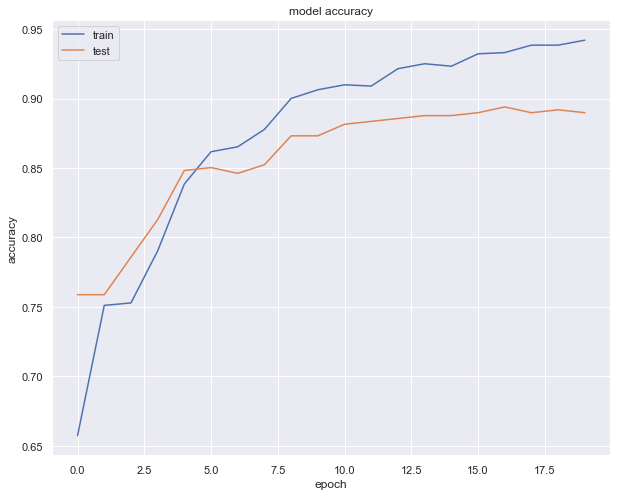

In [68]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.savefig('images/accuracy.png',  bbox_inches='tight')
plt.show()




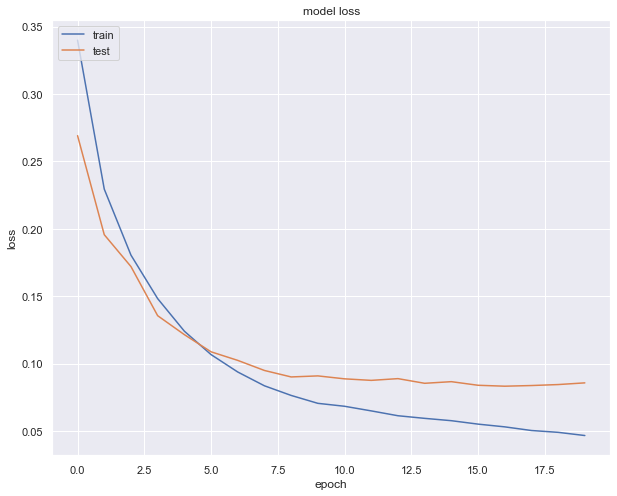

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig('images/loss.png')
plt.show()


In [70]:
import sklearn

predictions = model.predict(X_test)

y_pred = (predictions > 0.5)

<function matplotlib.pyplot.show(*args, **kw)>

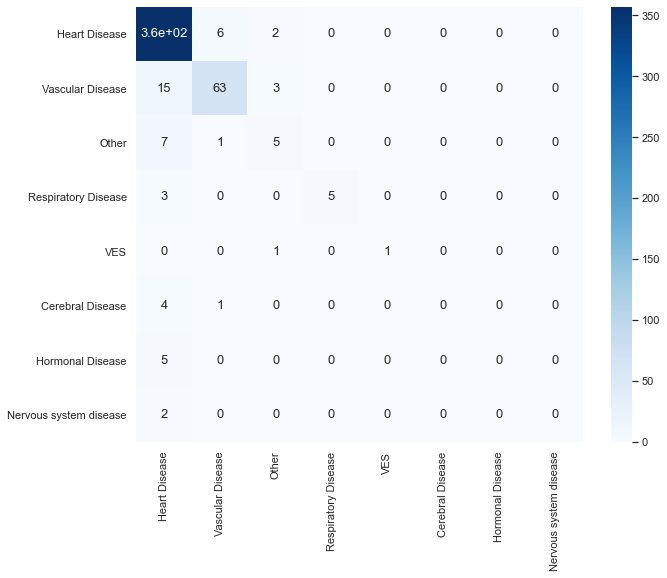

In [71]:
## Construction of confusion matrix

from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

array = matrix
df_cm = pd.DataFrame(array, index = [i for i in data['Label'].value_counts().index.values],
                  columns = [i for i in data['Label'].value_counts().index.values])

# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 13},cmap="Blues") # font size
plt.savefig('images/confusion_matrix.png')
plt.show

In [75]:
## weighted model

model.fit(X_train, y_train, batch_size=128, epochs=65, verbose=1, class_weight=d_class_weights, validation_data = (X_test, y_test))
history_weighted = model.fit(X_train, y_train, batch_size=128, epochs=2, verbose=1, class_weight=d_class_weights, validation_data = (X_test, y_test))

Epoch 1/65
9/9 [==============================] - 0s 19ms/step - loss: 9.5657e-04 - acc: 0.8296 - val_loss: 0.1353 - val_acc: 0.7360
Epoch 2/65
9/9 [==============================] - 0s 20ms/step - loss: 9.5125e-04 - acc: 0.8243 - val_loss: 0.1358 - val_acc: 0.7360
Epoch 3/65
9/9 [==============================] - 0s 20ms/step - loss: 9.3902e-04 - acc: 0.8305 - val_loss: 0.1361 - val_acc: 0.7360
Epoch 4/65
9/9 [==============================] - 0s 20ms/step - loss: 9.3086e-04 - acc: 0.8305 - val_loss: 0.1359 - val_acc: 0.7380
Epoch 5/65
9/9 [==============================] - 0s 20ms/step - loss: 9.2270e-04 - acc: 0.8314 - val_loss: 0.1359 - val_acc: 0.7401
Epoch 6/65
9/9 [==============================] - 0s 21ms/step - loss: 9.1506e-04 - acc: 0.8314 - val_loss: 0.1365 - val_acc: 0.7401
Epoch 7/65
9/9 [==============================] - 0s 21ms/step - loss: 9.0846e-04 - acc: 0.8305 - val_loss: 0.1368 - val_acc: 0.7401
Epoch 8/65
9/9 [==============================] - 0s 20ms/step - loss

In [76]:
f = plt.figure()
f.clear()
plt.close(f)

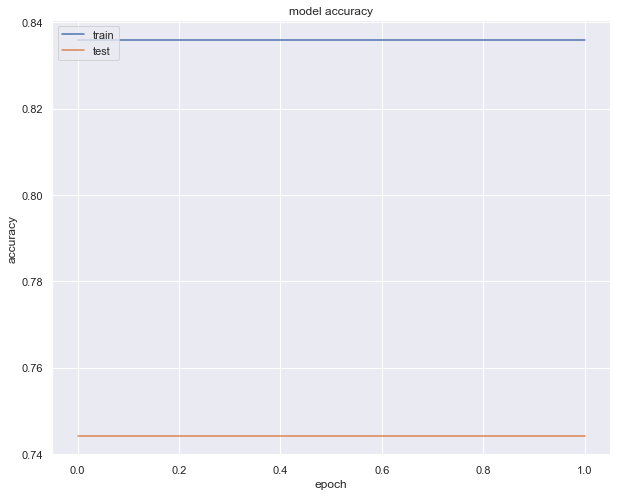

In [77]:


plt.plot(history_weighted.history['acc'])
plt.plot(history_weighted.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.savefig('images/accuracy_w.png',  bbox_inches='tight')
plt.show()

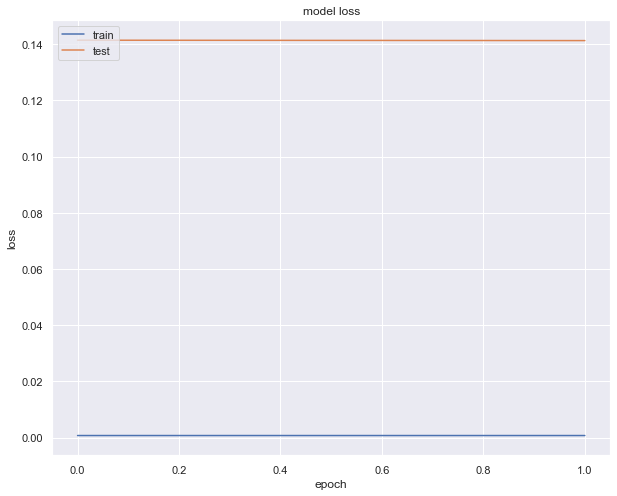

In [78]:
plt.plot(history_weighted.history['loss'])
plt.plot(history_weighted.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig('images/loss_w.png')
plt.show()

In [79]:
predictions = model.predict(X_test)

y_pred = (predictions > 0.5)

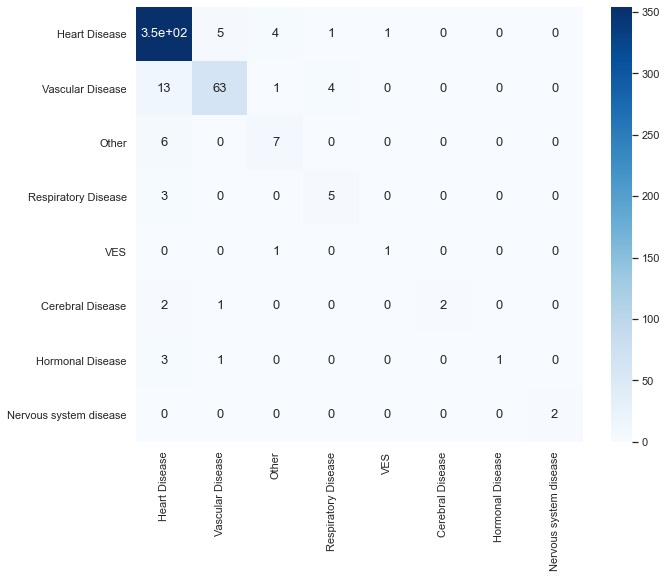

In [81]:
## Construction of confusion matrix

from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

array = matrix
df_cm = pd.DataFrame(array, index = [i for i in data['Label'].value_counts().index.values],
                  columns = [i for i in data['Label'].value_counts().index.values])

# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 13},cmap="Blues") # font size

plt.savefig('images/confusion_matrix_weighted.png')

# Test avec des nouvelles données de suivi

In [38]:
new_bd = pd.read_excel(r"new_cv_other.xlsx")

In [39]:
new_bd

CV-Other
0              Bypass
1             ARYTMIE
2             ARYTMIE
3               CHOPN
4    cysticka fibroza
..                ...
574        arrhythmia
575       Bradycardia
576        Arrhythmia
577         Arrythmia
578         Arrthymia

[579 rows x 1 columns]

In [40]:
new_bd.dropna(subset = ['CV-Other'], inplace=True) # drop missing values
new_bd = new_bd.sample(frac=1).reset_index(drop=True) # Shuffle the data set

In [41]:
new_bd

CV-Other
0                           Mekanisk hjerteklaff
1                                      Arrythmia
2                                PLM, Parasomnia
3    Atrial fibrillation, Takotsubocardiomyopati
4                                             AF
..                                           ...
574                                   Arrhythmia
575                            aortic dissection
576                                   arrhythmia
577                                    Arrythmia
578                          stent, arteriopathy

[579 rows x 1 columns]

In [42]:
## Cleaning the text of each new entry of the test dataset

X_new = []
entries = list(new_bd["CV-Other"])
for e in entries:
    X_new.append(preprocess_entry(e))

In [43]:
from nltk.tokenize import word_tokenize


## We call the texts_to_sequences function to convert entries to their numeric counterpart

embedded_new = tokenizer.texts_to_sequences(X_new)

## Find the number of words in the longest entry and then to apply padding to the sentences having shorter lengths than the length of the longest entry

word_count = lambda entry: len(word_tokenize(entry))

longest_entry = max(X_new, key=word_count)
maxlen = len(word_tokenize(longest_entry))

X_new = pad_sequences(embedded_new, padding='post', maxlen=maxlen)



In [44]:
predictions = model.predict(X_new)

y_pred = (predictions > 0.5)

In [45]:
y_pred

array([[False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False]])

In [46]:
labels = ["Heart Disease", "Vascular Disease", "Other", "Respiratory Disease", "VES", "Hormonal Disease", "Cerebral Disease", "Nervous system disease"]

In [47]:
len_i = len(y_pred)
len_j = len(y_pred[0])

In [48]:
range(len_i+1)[579]

579

In [49]:
cpt = 0
pred = []
pred_index = int()

for i in range(len_i):
    for j in range(len_j-1):
        if y_pred[i][j+1]<y_pred[i][j]:
            pred_index = j
    pred.append(labels[pred_index])

In [50]:
len(pred)

579

In [51]:
df1 = pd.DataFrame(new_bd)
df2 = pd.DataFrame(pred)
new_pred = pd.concat([df1, df2], axis = 1)
new_pred.columns = ['CV-Other', 'New-Labels']
new_pred

CV-Other        New-Labels
0                           Mekanisk hjerteklaff     Heart Disease
1                                      Arrythmia     Heart Disease
2                                PLM, Parasomnia     Heart Disease
3    Atrial fibrillation, Takotsubocardiomyopati     Heart Disease
4                                             AF     Heart Disease
..                                           ...               ...
574                                   Arrhythmia     Heart Disease
575                            aortic dissection     Heart Disease
576                                   arrhythmia     Heart Disease
577                                    Arrythmia     Heart Disease
578                          stent, arteriopathy  Vascular Disease

[579 rows x 2 columns]

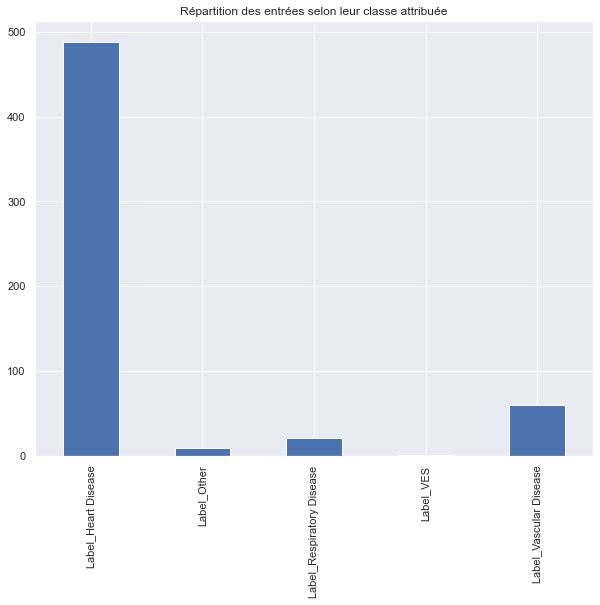

In [52]:
# use pd.concat to join the new columns (after one-hot encoding) with our original dataframe

df = pd.concat([new_pred,pd.get_dummies(new_pred['New-Labels'], prefix='Label')],axis=1)
df.drop(['New-Labels'],axis=1, inplace=True)

## Storing labels attributions in a list

df.drop(['CV-Other'],axis=1, inplace=True)
df_labels = df

fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.title('Répartition des entrées selon leur classe attribuée')

df_labels.sum(axis=0).plot.bar()


In [53]:
df

Label_Heart Disease  Label_Other  Label_Respiratory Disease  Label_VES  \
0                      1            0                          0          0   
1                      1            0                          0          0   
2                      1            0                          0          0   
3                      1            0                          0          0   
4                      1            0                          0          0   
..                   ...          ...                        ...        ...   
574                    1            0                          0          0   
575                    1            0                          0          0   
576                    1            0                          0          0   
577                    1            0                          0          0   
578                    0            0                          0          0   

     Label_Vascular Disease  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
..                      ...  
574                       0  
575                       0  
576                       0  
577                       0  
578                       1  

[579 rows x 5 columns]

In [54]:
for elt in df.columns:
    print(elt)

Label_Heart Disease
Label_Other
Label_Respiratory Disease
Label_VES
Label_Vascular Disease


In [55]:
is_heart = new_pred['New-Labels'] == 'Heart Disease'
new_pred_heart = new_pred[is_heart]
print(new_pred_heart)

                                        CV-Other     New-Labels
0                           Mekanisk hjerteklaff  Heart Disease
1                                      Arrythmia  Heart Disease
2                                PLM, Parasomnia  Heart Disease
3    Atrial fibrillation, Takotsubocardiomyopati  Heart Disease
4                                             AF  Heart Disease
..                                           ...            ...
573                                   arrhythmia  Heart Disease
574                                   Arrhythmia  Heart Disease
575                            aortic dissection  Heart Disease
576                                   arrhythmia  Heart Disease
577                                    Arrythmia  Heart Disease

[488 rows x 2 columns]


In [56]:
is_respi = new_pred['New-Labels'] == 'Respiratory Disease'
new_pred_respi = new_pred[is_respi]
print(new_pred_respi)

                                 CV-Other           New-Labels
18                      pulmonary embolus  Respiratory Disease
19                               arythmia  Respiratory Disease
20                           pericarditis  Respiratory Disease
63                    III degree AV block  Respiratory Disease
97                      pulmonary embolus  Respiratory Disease
98                                   PTCA  Respiratory Disease
303                     Pulmonary embolus  Respiratory Disease
317                    pulmonary embolism  Respiratory Disease
384                    pulmonary embolism  Respiratory Disease
385             AF,flutter, trombe i u.ex  Respiratory Disease
391  Tetralogy of Fallot (operated at 41)  Respiratory Disease
419                                   MTB  Respiratory Disease
420                    epicardic ischemia  Respiratory Disease
427                    Pulmonary embolism  Respiratory Disease
428           chronic atrial fibrillation  Respiratory 

In [57]:
is_vascular = new_pred['New-Labels'] == 'Vascular Disease'
new_pred_vascular = new_pred[is_vascular]
print(new_pred_vascular)

                                       CV-Other        New-Labels
35                               PTCA, stenting  Vascular Disease
36                                     arythmia  Vascular Disease
37                                      flimmer  Vascular Disease
38                               rythm disorder  Vascular Disease
72                              Thromboembolism  Vascular Disease
87                         venous insufficiency  Vascular Disease
92                       varices cruris surgery  Vascular Disease
93                                           AF  Vascular Disease
115                                    stenting  Vascular Disease
132                        Deep vein thrombosis  Vascular Disease
161                           varices operation  Vascular Disease
162                             Systolic murmur  Vascular Disease
163                         Sick Sinus syndrome  Vascular Disease
164                                 Hypothyroid  Vascular Disease
165       

In [58]:
is_cerebral = new_pred['New-Labels'] == 'Cerebral Disease'
new_pred_cerebral = new_pred[is_cerebral]
print(new_pred_cerebral)

Empty DataFrame
Columns: [CV-Other, New-Labels]
Index: []


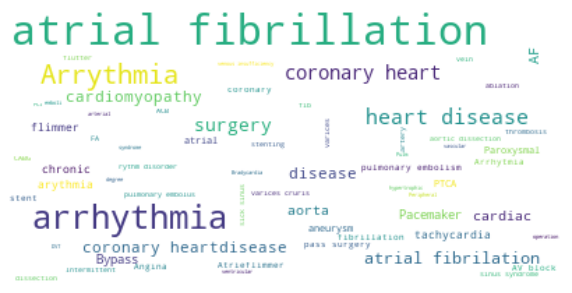

In [59]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(w for w in new_pred['CV-Other'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('images/wordcloud.png')
plt.show()

In [60]:
new_pred_respi

CV-Other           New-Labels
18                      pulmonary embolus  Respiratory Disease
19                               arythmia  Respiratory Disease
20                           pericarditis  Respiratory Disease
63                    III degree AV block  Respiratory Disease
97                      pulmonary embolus  Respiratory Disease
98                                   PTCA  Respiratory Disease
303                     Pulmonary embolus  Respiratory Disease
317                    pulmonary embolism  Respiratory Disease
384                    pulmonary embolism  Respiratory Disease
385             AF,flutter, trombe i u.ex  Respiratory Disease
391  Tetralogy of Fallot (operated at 41)  Respiratory Disease
419                                   MTB  Respiratory Disease
420                    epicardic ischemia  Respiratory Disease
427                    Pulmonary embolism  Respiratory Disease
428           chronic atrial fibrillation  Respiratory Disease
525                    pulmonary embolism  Respiratory Disease
526                             Arrhytmia  Respiratory Disease
562                    pulmonary embolism  Respiratory Disease
563                        Varices cruris  Respiratory Disease
570                                   MTB  Respiratory Disease
571                   Cardiac dysrhythmia  Respiratory Disease

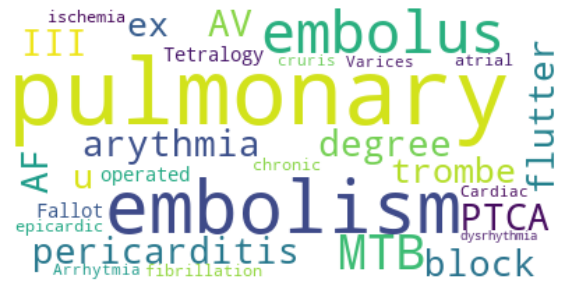

In [61]:
textt = " ".join(w for w in new_pred_respi['CV-Other'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('images/wordcloud_respi.png')
plt.show()

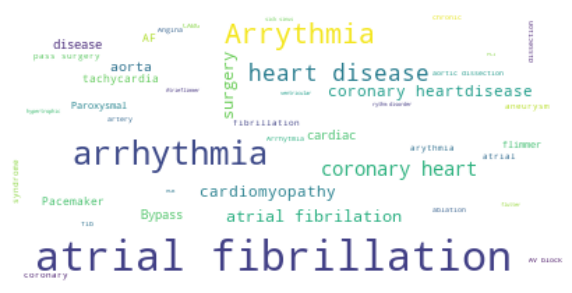

In [62]:
textt = " ".join(w for w in new_pred_heart['CV-Other'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('images/wordcloud_heart.png')
plt.show()

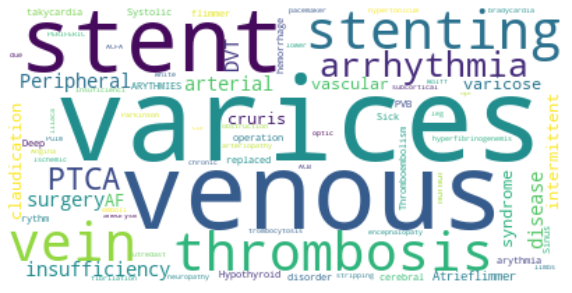

In [63]:
textt = " ".join(w for w in new_pred_vascular['CV-Other'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('images/wordcloud_vascular.png')
plt.show()